In [1]:
from tamkin import *
from molmod import *

import matplotlib.pyplot as plt
import numpy
import re

import sys
#sys.path.insert(0, '../code/')
from tamkintools_multi_fidelity_bayesian.tamkin_multi_fidelity import *

sys.path.insert(-1, '/home/derwer/Desktop/PHD/QM_ThermoKolloq22_multifidelity/')
from tamkintools import *
    
import os 
from datetime import date
np.bool = bool

### PI example utilizing Multi-Fidelity models

- The data are read in, normalized and a multi fidelity model is derived based on the weights. In addition, the periodicity of Rotor Experiments is exploited.
- Afterwards the multi fidelity model can be initialized. This includes the selection of the kernel. There is potential for optimization here. The default RBF kernel oscillates relatively strongly (especially when noise in training data is fixed to small numbers). Therefore in physical applications often Matern kernels are used, since these have smoother samples. Especially when derivatives of functions are to be determined.
- after initialization hyperparameters can be fixed 
- then the model is trained
- after training the high fidelity output is used to overwrite the initial data in the tamkin object
- tamkintools is used with the new data, weights are not necessary anymore




In [2]:
#############
# Constants #
#############
R = 8.3144598
R_a = 8.3144598
kcal = 4.1868 # kJ

level_prec = 200
T_plot     = 1
ExtRotSym  = 1

PIa            = load_molecule_g03fchk("scan_data/PI/PIafreq.fchk")
PIb            = load_molecule_g03fchk("scan_data/PI/PIbfreq.fchk")

scanPI         = load_rotscan_g03log("scan_data/PI/scan_PIa_p_repl.log")
angles, energies = scanPI.potential 
scanPI_corrected = erase_point_scan(scanPI,12)
corrected_angles, corrected_energies = scanPI_corrected.potential
print('angles in the orig_scan is: ' + str(angles))
ref_energy = min(energies)
print('ref energy in script is : ' +str(ref_energy))
#erased_angle = angles[12]
#erased_energies = energies[12]
#erase_potential = [erased_angles, erased_energies] 
angles, energies = scanPI_corrected.potential
print('the angles in corrected scan is: ' + str(corrected_angles))
erased_point = erase_point(scanPI, 12)
print('erased_points are in the script: ' +str(erased_point))
nma_PIa        = NMA(PIa, ConstrainExt())
nma_PIb        = NMA(PIb, ConstrainExt())

nma_angle = dihed_angle(nma_PIa.coordinates[scanPI_corrected.dihedral])[0]
ref_energy = potential_reference(scanPI, nma_angle)
print('ref energy is: ' +str(ref_energy)) 
scan_PIhigh = add_point(scanPI_corrected, -150.69257/180.0*numpy.pi, 3.08/2625.4995+ref_energy) #TShigh
scan_PIlow  = add_point(scan_PIhigh,         1.20334/180.0*numpy.pi, 1.04/2625.4995+ref_energy) #TSlow
scan_PI2    = add_point(scan_PIlow,        -33.81733/180.0*numpy.pi, 0.37/2625.4995+ref_energy) #TSlow
scan_PI3    = add_point(scan_PI2,           65.75423/180.0*numpy.pi, 0.00/2625.4995+ref_energy) #TSlow


myadded_points = [[-150.69257/180.0*numpy.pi,
		      1.20334/180.0*numpy.pi,
		    -33.81733/180.0*numpy.pi,
		     65.75423/180.0*numpy.pi],
                  [3.08/2625.4995+ref_energy,
		   1.04/2625.4995+ref_energy,
		   0.37/2625.4995+ref_energy,
		   0.00/2625.4995+ref_energy]]


myweights = [0.02 for i in range(24)]
myweights[12] = 0.0
myweights.append(100)
myweights.append(100)
myweights.append(100)
myweights.append(100)


myderivativevalues  = [0.0 for i in range(4)]
#myderivatepostition = [numpy.pi/180*180,numpy.pi/180*59.25,numpy.pi/180*37.69,37.69/180*95.11]
myderivatepostition = [-150.69257/180.0*numpy.pi,
		          1.20334/180.0*numpy.pi,
		        -33.81733/180.0*numpy.pi,
		         65.75423/180.0*numpy.pi]
myderivateweights = [0.1 for i in range(len(myderivatepostition))]
myderivative = [myderivativevalues,myderivatepostition,myderivateweights]

angles in the orig_scan is: [ 1.1476278   1.40942797  1.67122639  1.93302725  2.19482396  2.45662461
  2.7184251   2.98022019 -3.04115906 -2.77936506 -2.51756264 -2.25576694
 -1.99396468 -1.73216472 -1.47036585 -1.20856436 -0.94676699 -0.68496738
 -0.42317072 -0.16136472  0.10042949  0.36223282  0.62402719  0.88582707
  1.14762869]
ref energy in script is : -384.815763515
the angles in corrected scan is: [ 1.1476278   1.40942797  1.67122639  1.93302725  2.19482396  2.45662461
  2.7184251   2.98022019 -3.04115906 -2.77936506 -2.51756264 -2.25576694
 -1.73216472 -1.47036585 -1.20856436 -0.94676699 -0.68496738 -0.42317072
 -0.16136472  0.10042949  0.36223282  0.62402719  0.88582707  1.14762869]
erased_potential in combine_scans are: [[-1.9939646802173705], [-384.391592515]]
erased_points are in the script: [[-1.9939646802173705], [-384.391592515]]
ref energy is: -384.815763515


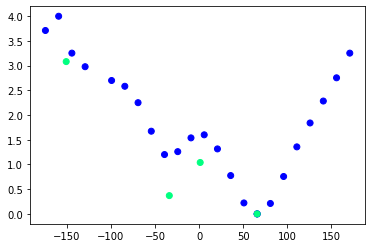

In [3]:
# plot scan data with weights
a, b = scan_PI3.potential
b = b*2625.5
b = b - np.min(b)
e_max = np.max(b)
a = a/np.pi*180
plt.scatter(a,b, c=myweights, cmap="winter")

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1.]
angle range: 344.9996181762406
set angle range 360


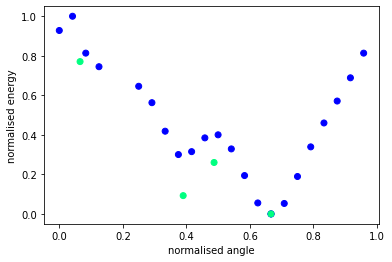

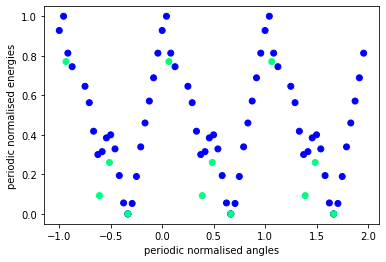

(81, 2)
(81, 1)
Optimization restart 1/5, f = -106.94294172201187
Optimization restart 2/5, f = -106.94294171879
Optimization restart 3/5, f = -106.94294172214776
Optimization restart 4/5, f = -106.94294172135317
Optimization restart 5/5, f = -106.9429417222347


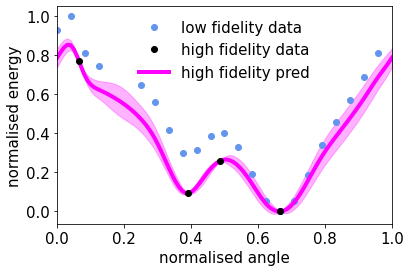

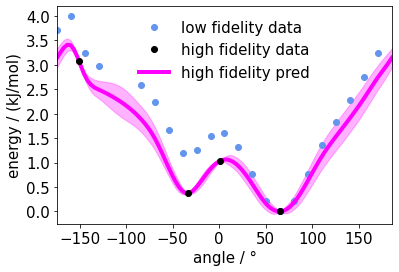

gp.,value,constraints,priors
multifidelity.Mat32.variance,0.32732318476127903,+ve,
multifidelity.Mat32.lengthscale,0.3339575302392985,+ve,
multifidelity.Mat32_1.variance,0.005820685769210324,+ve,
multifidelity.Mat32_1.lengthscale,0.1272921203066295,+ve,
multifidelity.scale,0.8189476023224861,,
mixed_noise.Gaussian_noise.variance,1e-07,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-07,+ve fixed,


In [4]:


# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( a, b, myweights, angle_range=2*180)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern32)

# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0000001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("normalised_multi_fidelity")
tmf.plot_results("multi_fidelity")

tmf.lin_mf_model.gpy_model


In [5]:
# predict values for initial datapoints
normed_angles = np.sort(np.linspace(0,1,100))
mf_angles, mf_energy, mf_std = tmf.predict_hf(normed_angles)
mf_angles = mf_angles / 180 * np.pi
mf_energy = mf_energy/ 2625.5


# overwrite initial datapoints with multi fidelity results
scan_PI3.potential = np.array( [mf_angles, mf_energy]  )

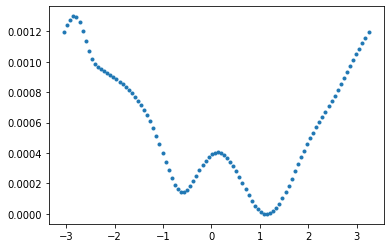

In [6]:
plt.plot( mf_angles, mf_energy, "." )

ref_energies are: -1.706380437810558e-10
relative energies in kjmol are: -1.706380437810558e-10
relative enrgies are: [-384.39159251]
Erased energies are: [-384.391592515]
length of erased Points are: 1
erased angles in for loop are: 245.75423932539184
erased angles in for loop are: -1009219.9004163784


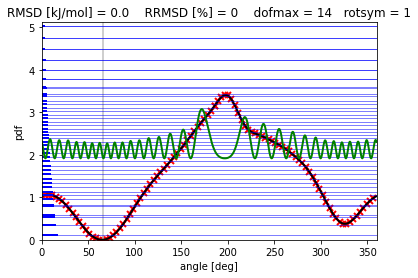

In [7]:
execute_tamkintools = True #False
if execute_tamkintools:
    #rotor          = Rotor(scanPI, PIa, rotsym=1, cancel_freq='scan', even=False, dofmax=10, num_levels=level_prec)
    #rotor          = Opt_Rotor(scan_PI3, PIa, rotsym=1, cancel_freq='scan', derivatives=myderivative, 
    #			   even=False, dofmax=14, num_levels=level_prec)
    rotor          = Opt_Rotor(scan_PI3, PIa, rotsym=1, cancel_freq='scan',
                   even=False, dofmax=14, num_levels=level_prec)

    # PartFun is part of tamkin!!!
    pf_PIa_HO      = PartFun(nma_PIa, [ExtTrans(), ExtRot(symmetry_number=ExtRotSym)])
    pf_PIb_HO      = PartFun(nma_PIb, [ExtTrans(), ExtRot(symmetry_number=ExtRotSym)])
    pf_PIa_HR      = PartFun(nma_PIa, [ExtTrans(), ExtRot(symmetry_number=ExtRotSym), rotor])

    pf_PIa_HO.write_to_file("PIa_HO.csv")
    pf_PIb_HO.write_to_file("PIb_HO.csv")
    pf_PIa_HR.write_to_file("PIa_HR_2.csv")
    #mypotential = self.rot_scan.potential
    rotor.plot_levels_all("PI_improved.png",T_plot,erased_points =erased_point,added_points = myadded_points)
    #rotor.plot_levels_all("PI_Optrotor_plotall_addederased.png",T_plot,erased_points =erased_point,added_points = myadded_points)

    thetas = np.asarray([1.20334,-150.69257])/180.0*numpy.pi

    #rotor.plot_P("PI",0)

    for i in range(30):
        rotor.plot_P("PI",i)
    #    P = rotor.residence_probability(thetas,i)
    #    for j in range(len(thetas)):
    #        print("residence probability between "+str(thetas[j])+" and "+str(thetas[j-1])+" at energy level "+str(i)+" is: "+str(P[j]))
    #P = rotor.residence_probability_T(thetas,298.15)
    #for j in range(len(thetas)):
    #    print("residence probability between "+str(thetas[j])+" and "+str(thetas[j-1])+" at temperature 298.15 Kelvin is: "+str(P[j]))

ref_energies are: -1.706380437810558e-10
relative energies in kjmol are: -1.706380437810558e-10
relative enrgies are: [-384.39159251]
Erased energies are: [-384.391592515]
length of erased Points are: 1
erased angles in for loop are: 245.75423932539184
erased angles in for loop are: -1009219.9004163784
ref_energies are: -1.706380437810558e-10
relative energies in kjmol are: -1.706380437810558e-10
relative enrgies are: [-384.39159251]
Erased energies are: [-384.391592515]
length of erased Points are: 1
erased angles in for loop are: 245.75423932539184
erased angles in for loop are: -1009219.9004163784


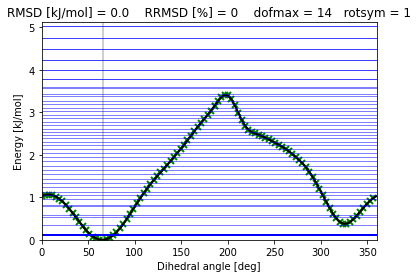

In [8]:
if execute_tamkintools:
    rotor.plot_levels_all("PI_fin.png",T_plot,erased_points =erased_point,added_points = myadded_points)
    rotor.plot_levels_all("PI_fin.pdf",T_plot,erased_points =erased_point,added_points = myadded_points)

## Standard GP

In [9]:
p = np.squeeze( np.where( tmf.periodic_fidelities == np.max(tmf.periodic_fidelities) ) )

ag = tmf.periodic_angles[p]
bg = tmf.periodic_energies[p]

kernel = GPy.kern.Matern32(1)
high_gp_model = GPy.models.GPRegression( np.atleast_2d( ag ).T, np.atleast_2d( bg ).T , kernel)
high_gp_model.Gaussian_noise.fix(0.0000001)

high_gp_model.optimize_restarts(5)

high_gp_model

Optimization restart 1/5, f = 5.33811872469605
Optimization restart 2/5, f = 5.3381187246950255
Optimization restart 3/5, f = 5.338118724696607
Optimization restart 4/5, f = 5.338118724696052
Optimization restart 5/5, f = 5.338118724723053


GP_regression.,value,constraints,priors
Mat32.variance,0.18917835054504037,+ve,
Mat32.lengthscale,0.17339757868474082,+ve,
Gaussian_noise.variance,1e-07,+ve fixed,


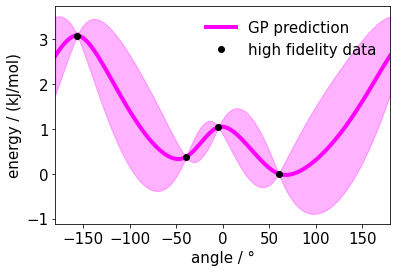

In [10]:
x_plot = np.atleast_2d( np.linspace(0,1,100) ).T
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(x_plot)
hf_std_hf_gp_model = np.sqrt(hf_var_high_gp_model)

x_plot = np.squeeze(x_plot)
hf_mean_high_gp_model = np.squeeze(hf_mean_high_gp_model)*e_max #*tmf.energy_range + tmf.energy_min
hf_std_hf_gp_model = np.squeeze(hf_std_hf_gp_model)*e_max #*tmf.energy_range

ndummy = x_plot*360 -180 #np.pi

plt.plot(ndummy, hf_mean_high_gp_model,"-",label="GP prediction",linewidth=tmf.lsize,color="magenta")
plt.fill_between(ndummy, hf_mean_high_gp_model-hf_std_hf_gp_model, hf_mean_high_gp_model+hf_std_hf_gp_model,
                 alpha=.3,color="magenta")

#plt.plot(ag*360-180, bg*tmf.energy_range + tmf.energy_min, ".k",label="high fidelity training data",markersize=tmf.msize)
plt.plot(ag*360-180, bg*e_max, ".k",label="high fidelity data",markersize=tmf.msize)


#plt.plot(data_c['deg'].to_numpy(),data_c['E'].to_numpy(),"k--", label="high fidelity data")

plt.xlim( (-180,180) )
plt.xlabel("angle / °",fontsize=tmf.fsize)
plt.ylabel("energy / (kJ/mol)",fontsize=tmf.fsize)
plt.xticks(fontsize=tmf.fsize)     
plt.yticks(fontsize=tmf.fsize)   

#plt.xticks( np.linspace( -1,1,5 )  ,np.linspace( -180, 180, 5) ,fontsize=tmf.fsize)  
plt.xlabel("angle / °",fontsize=tmf.fsize)

plt.legend(fontsize=tmf.fsize,frameon=False) #,loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.savefig("gp_on_high_fidelity.png", bbox_inches='tight')
plt.savefig("gp_on_high_fidelity.pdf", bbox_inches='tight')